# Test Case 6 - Single Inductance Not Connected to Ground

In [11]:
from CircuitCalculator.Circuit.state_space_model import state_space_model
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Setup Circuit

In [12]:
R1, R2, R3 = 10, 20, 30
L = 0.1
V0 = 5
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.inductance(id='L', L=L, nodes=('2', '3')),
    cmp.resistor(id='R3', R=R3, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

In [13]:
network=transform_circuit(circuit, w=0)

### Setup Solution

In [14]:
def step(t: np.ndarray) -> np.ndarray:
    return np.heaviside(t, 1)

In [15]:
t_max = 0.02
t0 = 0.001
Ts = t_max/1000
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

### Calculate Solution

In [16]:
from numpy.linalg import inv
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *
import CircuitCalculator.Network.NodalAnalysis.label_mapping as map
node_mapping = map.default_node_mapper(network)
voltage_source_mapper = map.alphabetic_voltage_source_mapper

l_labels = {'L': L}

A_tilde = nodal_analysis_coefficient_matrix(network).real

source_mapping = map.default_source_mapper(network)
Qi = source_incidence_matrix(
        network=network)


voltage_source_mapping = map.filter(voltage_source_mapper(network), lambda x: x not in l_labels)
inductance_mapping = map.filter(voltage_source_mapper(network), lambda x: x in l_labels)
voltage_source_mapping_all = voltage_source_mapper(network)

Q = np.zeros((voltage_source_mapping_all.N, voltage_source_mapping_all.N), dtype=int)
for l in voltage_source_mapping_all:
    Q[voltage_source_mapping_all[l]][voltage_source_mapping_all[l]] = 1
Q = np.vstack((np.zeros((node_mapping.N, voltage_source_mapping_all.N), dtype=int), Q))

QS = Q[:,voltage_source_mapping.values]
QL = Q[:,inductance_mapping.values]

QL = np.zeros((5, inductance_mapping.N), dtype=int)
for l in inductance_mapping:
    QL[node_mapping.N+inductance_mapping[l]][inductance_mapping[l]] = 1

L_inv = np.diag([1/L for L in l_labels.values()])

A = inv(QL.T@inv(A_tilde)@QL)@L_inv
B = -A * QL.T@inv(A_tilde)@QS

C = inv(A_tilde)@QL@inv(L_inv)@A
D = inv(A_tilde)@(QS+QL@inv(L_inv)@B)

In [17]:
sys = signal.StateSpace(A, B, C, D)
tout, yout, out = signal.lsim(sys, V, t)

### Calculate Reference Solution

In [18]:
def pll(R1, R2):
    return R1*R2/(R1+R2)

Ri = pll(R1, R2)+R3
tau = L/Ri

iL_ref = V*R2/(R1*R2+R1*R3+R2*R3)*(1-np.exp(-(tout-t0)/tau))
uL_ref = V*R2/(R1*R2+R1*R3+R2*R3)*L/tau*np.exp(-(tout-t0)/tau)

phi3_ref = R3*iL_ref
phi2_ref = phi3_ref + uL_ref
phi1_ref = V

iS_ref = (phi2_ref-phi1_ref)/R1

### Plot Solution

(0.0, 0.02)

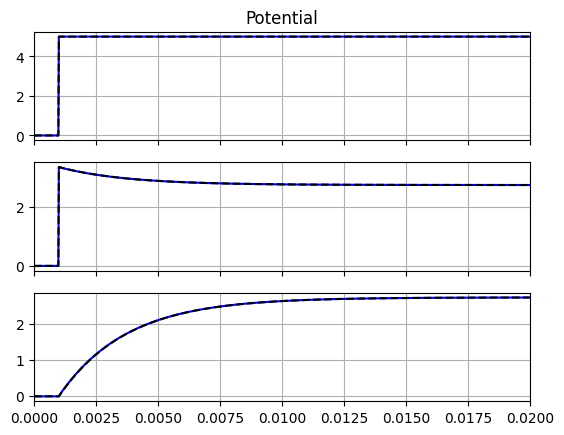

In [19]:
_, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(tout, yout[:,0], 'b-')
ax[0].plot(t, phi1_ref, 'k--')
ax[0].grid(True)
ax[0].set_title('Potential')

ax[1].plot(tout, yout[:,1], 'b-')
ax[1].plot(tout, phi2_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,2], 'b-')
ax[2].plot(tout, phi3_ref, 'k--')
ax[2].grid(True)
ax[2].set_xlim((0, t_max))

(0.0, 0.02)

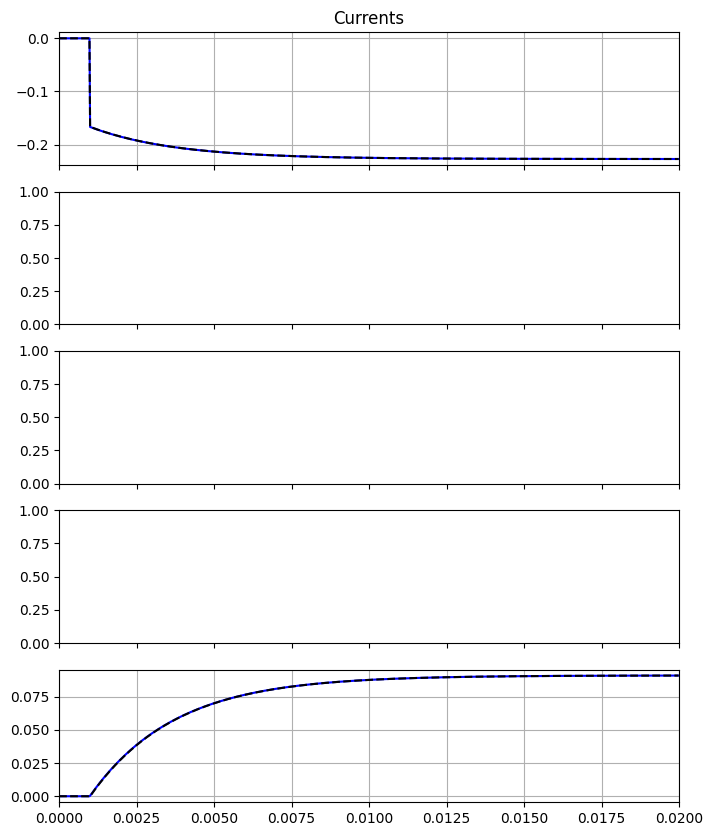

In [20]:
_, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))
ax[0].plot(tout, yout[:,4], 'b-')
ax[0].plot(t, iS_ref, 'k--')
ax[0].grid(True)
ax[0].set_title('Currents')

# ax[1].plot(tout, yout[:,9], 'b-')
# ax[1].plot(tout, i1_ref, 'k--')
# ax[1].grid(True)

# ax[2].plot(tout, yout[:,10], 'b-')
# ax[2].plot(tout, i2_ref, 'k--')
# ax[2].grid(True)

# ax[3].plot(tout, yout[:,11], 'b-')
# ax[3].plot(tout, i3_ref, 'k--')
# ax[3].grid(True)

ax[4].plot(tout, yout[:,3], 'b-')
ax[4].plot(tout, iL_ref, 'k--')
ax[4].grid(True)
ax[4].set_xlim((0, t_max))